In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

LANG_CHAIN_API_KEY = os.getenv("LANG_CHAIN_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", api_key=GEMINI_API_KEY, temperature=0
)



In [61]:
from langchain_openai import ChatOpenAI


def light(open: bool) -> int:
    """Turn on and off light.

    Args:
        a: light on and off bool
    """
    result = True
    return result


def fan_on() -> None:
    """Turn on the fan.
    """
    print("Fan is Turned ON")


def fan_off() -> None:
    """Turn off the fan."""
    print("Fan is Turned OFF")



def get_room_temprerature()->int:
    """Get current room temperature
    """
    return 25


def get_outdoor_temprerature() -> int:
    """Get current outdoor temperature"""
    return 32


tools = [fan_off, fan_on, get_room_temprerature, get_outdoor_temprerature]

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", api_key=GEMINI_API_KEY, temperature=0
)


llm_with_tools = llm.bind_tools(tools) 

In [30]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="You are a home automation assistant tasked with performing home controls automation depending on user input and weather conditions."
)

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

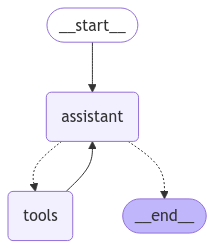

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph


def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

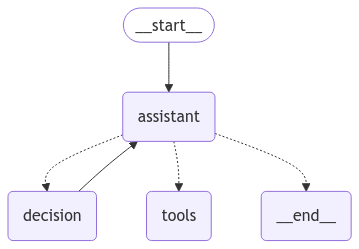

In [55]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph


# # Example custom condition for temperature control
# def assistant(state: MessagesState):
#     return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


def temperature_condition(latest_message, context):
    """
    Checks if the outdoor temperature is low and the room temperature is high.
    Returns the next node based on the condition.
    """
    outdoor_temp = context.get("outdoor_temperature")
    room_temp = context.get("room_temperature")

    # Example thresholds for temperature comparison
    if outdoor_temp < 15 and room_temp > 25:  # Low outdoor, high room
        context["action"] = "turn_on_fan"  # Add action to context
        return "fan_control"
    return "END"


# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("decision", temperature_condition)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",temperature_condition)
builder.add_edge("decision", "assistant")
# builder.add_edge("decision", "tools")

# builder.add_edge("tools", "assistant")
# builder.add_edge("fan_control", "assistant")

# Compile and visualize the graph
react_graph: CompiledStateGraph = builder.compile()

# Display the graph as an image
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [63]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [64]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [79]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)


planner = planner_prompt | ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", api_key=GEMINI_API_KEY, temperature=0
).with_structured_output(Plan)

In [80]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Find the current Australia open winner', 'Find the hometown of the current Australia open winner'])

In [82]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", api_key=GEMINI_API_KEY, temperature=0
).with_structured_output(Act)

In [83]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [84]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

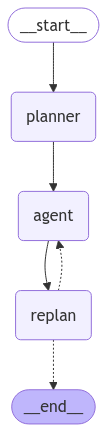

In [85]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [59]:
messages = [HumanMessage(content="what is temperature in room and outdoor? and turn fan on/off accordingly")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

Fan turned OFF! Action recorded in context.
Fan turned OFF! Action recorded in context.
Fan turned OFF! Action recorded in context.


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 Unable to submit request because it has an empty text parameter. Add a value to the parameter and try again. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini